### additional_analysis_combination_split_answer
- 最終更新: 2024/2/15, 14:05

- 追加分析: 採点基準表にちょっとずつ回答データを加えた場合のモデルのパフォーマンスの遷移の確認

#### Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 環境構築

aptやらpipやらの下準備
- 参考: https://qiita.com/karaage0703/items/30485c2ba1c396760982

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
!pip install fugashi ipadic unidic-lite
!pip install scikit-learn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
Suggested packages:
  apt-xapian-index aptitude-doc-en | aptitude-doc debtags tasksel libcwidget-dev xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
0 upgraded, 5 newly installed, 0 to remove and 33 not upgraded.
Need to get 3,838 kB of archives.
After this operation, 17.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aptitude-common all 0.8.13-3ubuntu1 [1,719 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsigc++-2.0-0v5 amd64 2.10.4-2ubuntu3 [12.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcwidget4 amd64 0.5.18-5build1 [306 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxapian30 amd64 1

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
#transformersの準備
!pip install transformers[torch] neologdn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 9.8 MB/s eta 0:00:00
  Created wheel for neologdn: filename=neologdn-0.5.2-cp310-cp310-linux_x86_64.whl size=219147 sha256=8da45946bfa9e0f05ac4e3a5a71ef9941eded49212ce93d9a9f3651a20375e5b
  Stored in directory: /root/.cache/pip/wheels/bd/87/af/2a36d74f666a8428943b70d71c5e9dd740435bf671f210672c
Successfully built neologdn


In [ ]:
pip install accelerate -U

In [ ]:
#GPUの認識状況の確認
!nvidia-smi

Thu Feb 15 02:20:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### 以下はコード

##### データの準備

In [ ]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import tqdm

In [ ]:
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from transformers import AdamW

In [ ]:
#乱数のseedを全固定する
#ref: https://qiita.com/ku_a_i/items/bac3befedbadab45774f
import random
import os
RANDOM_STATE = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(RANDOM_STATE)

In [ ]:
#採点基準表のデータを読み込む→ただし、study2_rubric_train_and_evalから持ってくる
data_rubric = pd.read_csv('/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study2/study2_rubric_train_and_eval/data_train.csv')
data_rubric = data_rubric.rename(columns={"scoring_key": "answer"})
data_rubric = data_rubric.drop(columns=["level_0", "index"])

data_rubric

,word_pair,word1,word2,answer,labels,text
0,鳥-飛行機,鳥,飛行機,飛ぶ,2,鳥[SEP]飛行機[SEP]飛ぶ
1,鳥-飛行機,鳥,飛行機,空を飛ぶ,2,鳥[SEP]飛行機[SEP]空を飛ぶ
2,鳥-飛行機,鳥,飛行機,空を飛ぶことができる,2,鳥[SEP]飛行機[SEP]空を飛ぶことができる
3,鳥-飛行機,鳥,飛行機,飛ぶことができる,2,鳥[SEP]飛行機[SEP]飛ぶことができる
4,鳥-飛行機,鳥,飛行機,空中を移動する,2,鳥[SEP]飛行機[SEP]空中を移動する
...,...,...,...,...,...,...
611,美術館-墓,美術館,墓,楽しい,0,美術館[SEP]墓[SEP]楽しい
612,美術館-墓,美術館,墓,ネットワーク状,0,美術館[SEP]墓[SEP]ネットワーク状
613,美術館-墓,美術館,墓,2つの要素が一つになる,0,美術館[SEP]墓[SEP]2つの要素が一つになる
614,美術館-墓,美術館,墓,平坦なシート,0,美術館[SEP]墓[SEP]平坦なシート


In [ ]:
data_rubric.shape

(616, 6)

In [ ]:
#採点基準表
print(len(data_rubric.word_pair.unique()))
print(data_rubric.word_pair.unique())

20
['鳥-飛行機' '剣-拳銃' 'みかん-ボール' '太陽-電球' '紙-葉っぱ' '山頂-針' '道-川' '愛-薬物' '山-障害物'
 '輪っか-ネックレス' 'なぞなぞ-迷宮' '時間-川' '会社-木' '酒場-教会' '理論-建物' 'ダイヤモンド -雪片' '記憶-牢獄'
 '結婚-合金' '思考-網' '美術館-墓']


In [ ]:
#実験1の回答データの準備
data_answer = pd.read_csv("/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/data/20230213_PreExp_SST_ClassifyAnswer_v5.1.csv")
data_answer

,order,trial_index,time_elapsed,cwid,StartTime,EndTime,rt,word_pair,answer,SHに基づく得点,SH：補足,PickedSample,Classification_ksm,Classification_oka,ageement,CR_ksm,CR_oka,FinalRating,Note_ksm,Note_oka
0,1,2,33223,275026,44928.92420,44928.92715,15459,鳥 - 飛行機,とぶもの,2,NaN,1,2.0,2,1.0,NaN,NaN,2,NaN,NaN
1,2,3,41046,275026,44928.92420,44928.92715,7810,剣 - 拳銃,攻撃するもの,1,攻撃するという共通点だけ,0,NaN,1,NaN,NaN,NaN,1,NaN,NaN
2,3,4,50740,275026,44928.92420,44928.92715,9687,みかん - ボール,球状,2,球状は球形の同義語,0,NaN,2,NaN,NaN,NaN,2,NaN,NaN
3,4,5,55109,275026,44928.92420,44928.92715,4346,太陽 - 電球,光る,2,NaN,0,NaN,2,NaN,NaN,NaN,2,NaN,NaN
4,5,6,60701,275026,44928.92420,44928.92715,5565,紙 - 葉っぱ,平たい,1,平たいシートである点がポイント、平たいは低次の共通点,0,NaN,1,NaN,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,21,204228,1052834,44929.48289,44929.48591,6198,結婚 - 合金,合わせる,2,NaN,0,NaN,2,NaN,NaN,NaN,2,NaN,NaN
1916,1917,22,231500,1052834,44929.48289,44929.48591,27269,思考 - 網,アメーバ状,2,v2で2点に変更,0,NaN,2,NaN,NaN,NaN,2,NaN,NaN
1917,1918,23,248260,1052834,44929.48289,44929.48591,16758,学位 - 橋,昇り詰める,1,そういう橋があるのは事実,0,NaN,1,NaN,NaN,NaN,1,NaN,NaN
1918,1919,24,256516,1052834,44929.48289,44929.48591,8254,美術館 - 墓,飾る,1,骨/ものを飾るか,0,NaN,1,NaN,NaN,NaN,1,NaN,NaN


In [ ]:
#trial_indexで以下を除外
#Oka, Utsumi, & Kusumi (under review)では項目選定の都合で以下の項目についても利用していたが、最終的には利用しなかった。
#詳細はhttps://github.com/okaexp/Japanese_version_of_SST

#12: 孤独-砂漠
#20: 鍵-答え
#23: 学位-橋
#25: 若者-鳥

data_answer = data_answer[~data_answer["trial_index"].isin([12, 20, 23, 25])]
print(data_answer.trial_index.unique())
print(data_answer.word_pair.unique())
print(len(data_answer.trial_index.unique()))

[ 2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 21 22 24]
['鳥 - 飛行機' '剣 - 拳銃' 'みかん - ボール' '太陽 - 電球' '紙 - 葉っぱ' '山頂 - 針' '道 - 川'
 '愛 - 薬物' '山 - 障害物' '輪っか - ネックレス' 'なぞなぞ - 迷宮' '時間 - 川' '会社 - 木' '酒場 - 教会'
 '理論 - 建物' 'ダイヤモンド - 雪片' '記憶 - 牢獄' '結婚 - 合金' '思考 - 網' '美術館 - 墓']
20


In [ ]:
#単語1, 単語2, 参加者の回答, 回答に対するlabels(FianlRatingの名前をlabelsとした)
data_answer = data_answer.loc[:, ["word_pair", "answer", "FinalRating"]]
data_answer = pd.concat([data_answer, data_answer['word_pair'].str.split('-', expand=True)], axis=1).drop('word_pair', axis=1)
data_answer = data_answer.rename(columns={0: 'word1', 1: 'word2', "FinalRating": "labels"})
data_answer = data_answer.reindex(columns=["word1", "word2", "answer", "labels"])
data_answer

,word1,word2,answer,labels
0,鳥,飛行機,とぶもの,2
1,剣,拳銃,攻撃するもの,1
2,みかん,ボール,球状,2
3,太陽,電球,光る,2
4,紙,葉っぱ,平たい,1
...,...,...,...,...
1912,ダイヤモンド,雪片,美しい,1
1913,記憶,牢獄,覚える,0
1915,結婚,合金,合わせる,2
1916,思考,網,アメーバ状,2


In [ ]:
#なぜかword1/word2にスペースが混ざっているケースがあったので削除する
def remove_dumb_spaces(string):
  return string.rstrip().lstrip()

#データセットのための準備
data_answer["word1"] = data_answer["word1"].map(remove_dumb_spaces)
data_answer["word2"] = data_answer["word2"].map(remove_dumb_spaces)
data_answer["text"] = data_answer['word1'] + "[SEP]" + data_answer["word2"] + "[SEP]" + data_answer["answer"]
data_answer

,word1,word2,answer,labels,text
0,鳥,飛行機,とぶもの,2,鳥[SEP]飛行機[SEP]とぶもの
1,剣,拳銃,攻撃するもの,1,剣[SEP]拳銃[SEP]攻撃するもの
2,みかん,ボール,球状,2,みかん[SEP]ボール[SEP]球状
3,太陽,電球,光る,2,太陽[SEP]電球[SEP]光る
4,紙,葉っぱ,平たい,1,紙[SEP]葉っぱ[SEP]平たい
...,...,...,...,...,...
1912,ダイヤモンド,雪片,美しい,1,ダイヤモンド[SEP]雪片[SEP]美しい
1913,記憶,牢獄,覚える,0,記憶[SEP]牢獄[SEP]覚える
1915,結婚,合金,合わせる,2,結婚[SEP]合金[SEP]合わせる
1916,思考,網,アメーバ状,2,思考[SEP]網[SEP]アメーバ状


In [ ]:
#data_basicからユニークな回答（word1ごとのanswerをユニークにする）を抽出する
#重複する回答はモデル学習/評価時にリークする恐れがあるため除外する
#ref: https://tiruka.hatenablog.jp/entry/2018/09/07/120553
data_answer_unique = data_answer.drop_duplicates(subset=['word1', 'word2', 'answer', 'labels'], keep='first')
data_answer_unique = data_answer_unique.reset_index()
data_answer_unique

,index,word1,word2,answer,labels,text
0,0,鳥,飛行機,とぶもの,2,鳥[SEP]飛行機[SEP]とぶもの
1,1,剣,拳銃,攻撃するもの,1,剣[SEP]拳銃[SEP]攻撃するもの
2,2,みかん,ボール,球状,2,みかん[SEP]ボール[SEP]球状
3,3,太陽,電球,光る,2,太陽[SEP]電球[SEP]光る
4,4,紙,葉っぱ,平たい,1,紙[SEP]葉っぱ[SEP]平たい
...,...,...,...,...,...,...
1214,1910,酒場,教会,のめり込む,1,酒場[SEP]教会[SEP]のめり込む
1215,1911,理論,建物,硬い,1,理論[SEP]建物[SEP]硬い
1216,1913,記憶,牢獄,覚える,0,記憶[SEP]牢獄[SEP]覚える
1217,1916,思考,網,アメーバ状,2,思考[SEP]網[SEP]アメーバ状


### 回答データ（`data_answer_unique`）を10分割する
- `study1_answer_task_train_and_eval_v0.1.ipynb`を参考に

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
NUM_FOLDS = 10

def create_stratifiedkfolds(df):
  """
  stratified k foldされたデータセットを返す関数を書く
  ref: https://www.kaggle.com/code/abhishek/step-1-create-folds/notebook
  """
  # we create a new column called kfold and fill it with -1
  df["kFold"] = -1

  # calculate number of bins by Sturge's rule
  # I take the floor of the value, you can also
  # just round it
  num_bins = int(np.floor(1 + np.log2(len(df))))

  # bin targets
  df.loc[:, "bins"] = pd.cut(
      df["labels"], bins=num_bins, labels=False
  )

  # initiate the kfold class from model_selection module
  kf = model_selection.StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_STATE)

  # fill the new kfold column
  # note that, instead of targets, we use bins!
  for f, (t_, v_) in enumerate(kf.split(X=df, y=df.bins.values)):
      df.loc[v_, 'kFold'] = f

  # drop the bins column
  df = df.drop("bins", axis=1)

  return df

In [ ]:
data_answer_unique_with_folds = create_stratifiedkfolds(data_answer_unique)
data_answer_unique_with_folds

,index,word1,word2,answer,labels,text,kFold
0,0,鳥,飛行機,とぶもの,2,鳥[SEP]飛行機[SEP]とぶもの,3
1,1,剣,拳銃,攻撃するもの,1,剣[SEP]拳銃[SEP]攻撃するもの,4
2,2,みかん,ボール,球状,2,みかん[SEP]ボール[SEP]球状,1
3,3,太陽,電球,光る,2,太陽[SEP]電球[SEP]光る,8
4,4,紙,葉っぱ,平たい,1,紙[SEP]葉っぱ[SEP]平たい,1
...,...,...,...,...,...,...,...
1214,1910,酒場,教会,のめり込む,1,酒場[SEP]教会[SEP]のめり込む,9
1215,1911,理論,建物,硬い,1,理論[SEP]建物[SEP]硬い,1
1216,1913,記憶,牢獄,覚える,0,記憶[SEP]牢獄[SEP]覚える,7
1217,1916,思考,網,アメーバ状,2,思考[SEP]網[SEP]アメーバ状,1


In [ ]:
#kFoldの内訳確認
data_answer_unique_with_folds.value_counts(subset=["labels", "kFold"])

labels  kFold
1       5        59
        9        59
        4        59
        3        59
        2        59
        1        59
        0        59
        7        58
        6        58
        8        58
2       2        55
        3        55
        4        55
        5        55
        6        55
        0        55
        7        55
        8        55
        1        55
        9        54
0       8         9
        7         9
        6         9
        1         8
        9         8
        5         8
        4         8
        3         8
        2         8
        0         8
dtype: int64

### 回答データを基準表にくっつける練習

In [ ]:
#くっつける回答データの準備
tmp_num_fold = 1
tmp_num_fold_lst = range(tmp_num_fold)#1~10までのリストで持つ
tmp_split_answers = data_answer_unique_with_folds.query('kFold in @tmp_num_fold_lst')
tmp_split_answers = tmp_split_answers[["word1",	"word2",	"answer",	"labels",	"text",	"kFold"]]

tmp_split_answers

,word1,word2,answer,labels,text,kFold
9,輪っか,ネックレス,和状,0,輪っか[SEP]ネックレス[SEP]和状,0
18,思考,網,ネットワーク,2,思考[SEP]網[SEP]ネットワーク,0
27,山,障害物,大きい,1,山[SEP]障害物[SEP]大きい,0
32,理論,建物,構造,2,理論[SEP]建物[SEP]構造,0
35,結婚,合金,幸福,0,結婚[SEP]合金[SEP]幸福,0
...,...,...,...,...,...,...
1160,紙,葉っぱ,平べったい事,1,紙[SEP]葉っぱ[SEP]平べったい事,0
1161,山頂,針,尖っていること,2,山頂[SEP]針[SEP]尖っていること,0
1194,思考,網,思考は脳内で、網は現実世界で四方八方に張り巡らせる点が似ています,2,思考[SEP]網[SEP]思考は脳内で、網は現実世界で四方八方に張り巡らせる点が似ています,0
1198,輪っか,ネックレス,首にかけれる,1,輪っか[SEP]ネックレス[SEP]首にかけれる,0


In [ ]:
#採点基準表とくっつける回答データを結合
tmp_data_rubric = data_rubric[["word1",	"word2",	"answer",	"labels",	"text"]]
tmp_data_rubric["kFold"] = tmp_num_fold - 1
tmp_data_rubric_and_split_answers = pd.concat([tmp_data_rubric, tmp_split_answers])
tmp_data_rubric_and_split_answers = tmp_data_rubric_and_split_answers.reset_index()
tmp_data_rubric_and_split_answers

,index,word1,word2,answer,labels,text,kFold
0,0,鳥,飛行機,飛ぶ,2,鳥[SEP]飛行機[SEP]飛ぶ,0
1,1,鳥,飛行機,空を飛ぶ,2,鳥[SEP]飛行機[SEP]空を飛ぶ,0
2,2,鳥,飛行機,空を飛ぶことができる,2,鳥[SEP]飛行機[SEP]空を飛ぶことができる,0
3,3,鳥,飛行機,飛ぶことができる,2,鳥[SEP]飛行機[SEP]飛ぶことができる,0
4,4,鳥,飛行機,空中を移動する,2,鳥[SEP]飛行機[SEP]空中を移動する,0
...,...,...,...,...,...,...,...
733,1160,紙,葉っぱ,平べったい事,1,紙[SEP]葉っぱ[SEP]平べったい事,0
734,1161,山頂,針,尖っていること,2,山頂[SEP]針[SEP]尖っていること,0
735,1194,思考,網,思考は脳内で、網は現実世界で四方八方に張り巡らせる点が似ています,2,思考[SEP]網[SEP]思考は脳内で、網は現実世界で四方八方に張り巡らせる点が似ています,0
736,1198,輪っか,ネックレス,首にかけれる,1,輪っか[SEP]ネックレス[SEP]首にかけれる,0


### モデルの訓練と評価の準備


In [ ]:
#cudaを使う準備
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
from datasets import Dataset
def create_dataset(data_all):
  """
  dataset（pandasのデータフレーム）をtorchで使えるデータセットにする
  """

  def tokenize_basic(batch):
      return tokenizer(batch["text"], padding=True, truncation=True)

  data_all = data_all.reset_index()
  dataset_all = Dataset.from_pandas(data_all)
  dataset_all_encoded = dataset_all.map(tokenize_basic, batched=True, batch_size=None)

  return dataset_all_encoded, data_all


# メトリクスの定義
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#Trainerの重みを変えるやつ
#imbalanced dataのlossの定義
#ref: https://huggingface.co/docs/transformers/main/main_classes/trainer
#ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        #2023/4/6: debug
        # print("compute_loss: labels, logits", labels, logits)
        # print("compute_loss: outputs: ", outputs)

        # compute custom loss (suppose one has 3 labels with different weights)
        # 訓練データの正例の逆数で重み付け
        loss_fct = nn.CrossEntropyLoss(weight=cur_config["weight_all"])
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        #print()
        # print("loss_fct: ", loss_fct)
        # print("loss: ", loss)

        return (loss, outputs) if return_outputs else loss

def load_bert_model_and_tokenizer():
  """
  BERTのモデルとトークナイザを呼び出す関数
  ※都度初期化して呼び出したいため、ここで呼ぶ
  """

  model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
  model = model.to(device)
  tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

  return model, tokenizer


class load_config:
  """
  cur_fold_idxを引数として、そのfoldにおけるlogging_stepsとweight_allを受け取る
  """
  #初期化
  def __init__(self):
    self.config = dict()

  def create_logging_steps(self):
    self.config["logging_steps"] = len(tmp_data_rubric_and_split_answers) // BATCH_SIZE

  def create_weight_all(self):
    """
    weight_allを計算する
    ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
    ref_conc: weight_all = torch.tensor([len(data_basic_unique_train)/75, len(data_basic_unique_train)/528, len(data_basic_unique_train)/494]).clone().to(device, torch.float32)
    """
    self.config["weight_all"] = torch.tensor([len(tmp_data_rubric_and_split_answers) /len(tmp_data_rubric_and_split_answers.query('labels == 0')),
                                            len(tmp_data_rubric_and_split_answers) /len(tmp_data_rubric_and_split_answers.query('labels == 1')),
                                            len(tmp_data_rubric_and_split_answers) /len(tmp_data_rubric_and_split_answers.query('labels == 2'))]).clone().to(device, torch.float32)

  def return_config(self):
    self.create_logging_steps()
    self.create_weight_all()
    return self.config

#結果の評価
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
def plot_confusion_matrix(y_preds, y_true, output_dir):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.savefig(output_dir+"confusion_matrix.png")
    plt.show()

def tokenize_basic(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

### 評価データセット（Exp1の結果）の準備

In [ ]:
#評価データの読み込み
data_eval = pd.read_excel('/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/data/20230412_edited_dat_after_aggregate_v0.1.xlsx', sheet_name=0, index_col=None)
data_eval = data_eval[data_eval["trial_type"].isin(["survey-text"])]
data_eval

,order,success,trial_type,trial_index,time_elapsed,internal_node_id,cwid,StartTime,EndTime,rt,...,answer,point_oka,point_ksm,PickedSample,CR_oka,CR_ksm,FinalRating,comment_oka,Note_ksm,agreement
2,3,NaN,survey-text,2,49173,0.0-2.0-0.0,4409144,44965.513553,44965.516238,10801.0,...,飛ぶ,2.0,2.0,1,NaN,NaN,2.0,NaN,NaN,1.0
3,4,NaN,survey-text,3,56325,0.0-2.0-1.0,4409144,44965.513553,44965.516238,7143.0,...,流れる,2.0,2.0,1,NaN,NaN,2.0,NaN,NaN,1.0
4,5,NaN,survey-text,4,63074,0.0-2.0-2.0,4409144,44965.513553,44965.516238,6722.0,...,座る,1.0,NaN,0,NaN,NaN,1.0,採点基準表にない; 部分的特徴を掴んでいる。,NaN,NaN
5,6,NaN,survey-text,5,71457,0.0-2.0-3.0,4409144,44965.513553,44965.516238,8355.0,...,とがっている,2.0,NaN,0,NaN,NaN,2.0,NaN,NaN,NaN
6,7,NaN,survey-text,6,78877,0.0-2.0-4.0,4409144,44965.513553,44965.516238,7392.0,...,丸い,2.0,NaN,0,NaN,NaN,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,2295,NaN,survey-text,17,537831,0.0-2.0-15.0,4222839,44966.393275,44966.401551,8130.0,...,形が似ている,1.0,NaN,0,NaN,NaN,1.0,NaN,NaN,NaN
2295,2296,NaN,survey-text,18,586939,0.0-2.0-16.0,4222839,44966.393275,44966.401551,49103.0,...,キラキラと光っている所,1.0,NaN,0,NaN,NaN,1.0,NaN,NaN,NaN
2296,2297,NaN,survey-text,19,628582,0.0-2.0-17.0,4222839,44966.393275,44966.401551,41641.0,...,車、水が流れているように見えるところ,1.0,NaN,0,NaN,NaN,1.0,NaN,NaN,NaN
2297,2298,NaN,survey-text,20,651652,0.0-2.0-18.0,4222839,44966.393275,44966.401551,23066.0,...,厚さが薄い所,1.0,NaN,0,NaN,NaN,1.0,NaN,NaN,NaN


In [ ]:
data_eval.columns

Index(['order', 'success', 'trial_type', 'trial_index', 'time_elapsed',
       'internal_node_id', 'cwid', 'StartTime', 'EndTime', 'rt', 'stimulus',
       'response', 'task', 'word_pair', 'answer', 'point_oka', 'point_ksm',
       'PickedSample', 'CR_oka', 'CR_ksm', 'FinalRating', 'comment_oka',
       'Note_ksm', 'agreement'],
      dtype='object')

In [ ]:
#この処理で仮置きのtokenizerが必要
MODEL_NAME = "cl-tohoku/bert-base-japanese"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

#単語1, 単語2, 参加者の回答, 回答に対するlabels(FianlRatingの名前をlabelsとした)
data_eval = data_eval.loc[:, ["word_pair", "answer", "FinalRating"]]
data_eval = pd.concat([data_eval, data_eval['word_pair'].str.split('-', expand=True)], axis=1).drop('word_pair', axis=1)
data_eval = data_eval.rename(columns={0: 'word1', 1: 'word2', "FinalRating": "labels"})
data_eval = data_eval.reindex(columns=["word1", "word2", "answer", "labels"])
data_eval_unique = data_eval.drop_duplicates(subset=['word1', 'word2', 'answer', 'labels'], keep='first')
data_eval_unique["text"] = data_eval_unique['word1'] + "[SEP]" + data_eval_unique["word2"] + "[SEP]" + data_eval_unique["answer"]
data_eval_unique = data_eval_unique.dropna(subset=["word1", "word2"], how="all")
data_eval_unique["labels"] = data_eval_unique["labels"].astype(int)

data_eval_unique_reset_index = data_eval_unique.reset_index()
dataset_eval_unique_reset_index = Dataset.from_pandas(data_eval_unique_reset_index)
dataset_eval_unique_reset_index_encoded = dataset_eval_unique_reset_index.map(tokenize_basic, batched=True, batch_size=None)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.
<ipython-input-67-2e6e66a8028e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval_unique["text"] = data_eval_unique['word1'] + "[SEP]" + data_eval_unique["word2"] + "[SEP]" + data_eval_unique["answer"]


Map:   0%|          | 0/1309 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
dataset_eval_unique_reset_index_encoded

Dataset({
    features: ['index', 'word1', 'word2', 'answer', 'labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1309
})

#### モデルの訓練と評価
- 46分程度かかる

CUR_FOLD:  0


Map:   0%|          | 0/738 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.096300,1.003780,0.551491,0.556866
2,1.002800,0.884232,0.628726,0.599640
3,0.920300,0.760024,0.663957,0.615181
4,0.812700,0.646037,0.728997,0.726201
5,0.759500,0.578272,0.775068,0.766297
6,0.654000,0.492513,0.821138,0.812924
7,0.597700,0.423584,0.837398,0.835643
8,0.547700,0.377375,0.848238,0.847381
9,0.479800,0.339385,0.882114,0.881626
10,0.438700,0.330712,0.879404,0.878883


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/Fold0/checkpoint-240


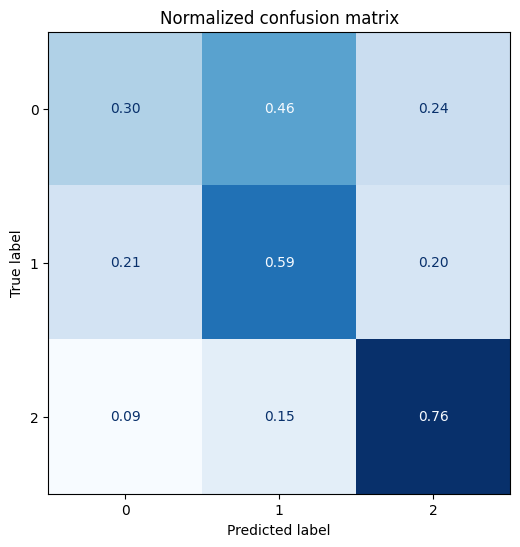

              precision    recall  f1-score   support

           2       0.17      0.30      0.21       120
           1       0.73      0.59      0.65       630
           0       0.73      0.76      0.75       559

    accuracy                           0.64      1309
   macro avg       0.54      0.55      0.54      1309
weighted avg       0.68      0.64      0.65      1309

CUR_FOLD:  1


Map:   0%|          | 0/860 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.095600,1.031723,0.436047,0.385729
2,1.021100,0.868276,0.660465,0.651048
3,0.890900,0.692662,0.745349,0.748065
4,0.788300,0.561132,0.812791,0.813454
5,0.659500,0.424733,0.865116,0.864986
6,0.547300,0.346158,0.902326,0.901599
7,0.471800,0.282079,0.918605,0.918413
8,0.394200,0.213635,0.961628,0.961620
9,0.360500,0.188814,0.960465,0.960421
10,0.335700,0.182787,0.960465,0.960422


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/Fold1/checkpoint-270


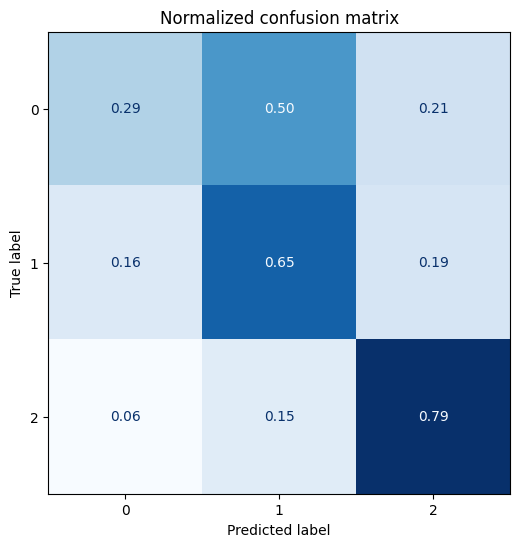

              precision    recall  f1-score   support

           2       0.20      0.29      0.24       120
           1       0.74      0.65      0.69       630
           0       0.76      0.79      0.77       559

    accuracy                           0.68      1309
   macro avg       0.57      0.58      0.57      1309
weighted avg       0.70      0.68      0.69      1309

CUR_FOLD:  2


Map:   0%|          | 0/982 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.107600,1.016357,0.571283,0.579774
2,0.991800,0.863100,0.608961,0.599945
3,0.886000,0.660251,0.766802,0.766316
4,0.730800,0.479870,0.820774,0.820864
5,0.580600,0.361542,0.865580,0.865027
6,0.491200,0.256927,0.936864,0.936673
7,0.396700,0.200833,0.945010,0.945099
8,0.341900,0.154934,0.967413,0.967359
9,0.294400,0.128485,0.975560,0.975528
10,0.257600,0.118741,0.980652,0.980638


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/Fold2/checkpoint-310


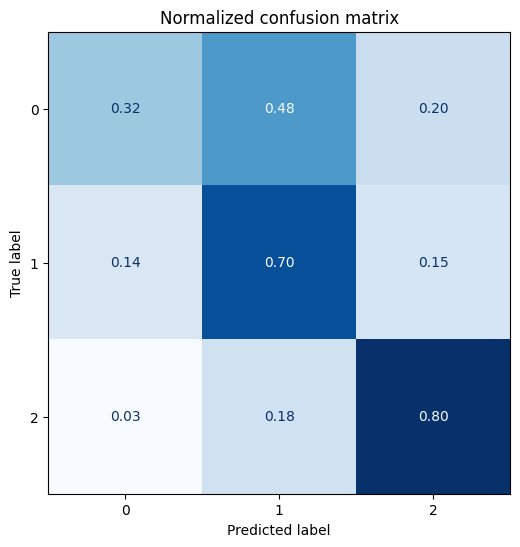

              precision    recall  f1-score   support

           2       0.27      0.32      0.29       120
           1       0.74      0.70      0.72       630
           0       0.79      0.80      0.79       559

    accuracy                           0.71      1309
   macro avg       0.60      0.61      0.60      1309
weighted avg       0.72      0.71      0.71      1309

CUR_FOLD:  3


Map:   0%|          | 0/1104 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.092200,1.001611,0.513587,0.498785
2,0.988600,0.864297,0.624094,0.629630
3,0.888700,0.805559,0.597826,0.571515
4,0.763600,0.556687,0.743659,0.743835
5,0.631600,0.454349,0.785326,0.782258
6,0.532900,0.372349,0.866848,0.865068
7,0.495200,0.277977,0.897645,0.898281
8,0.401000,0.226873,0.926630,0.927327
9,0.346600,0.198525,0.927536,0.928217
10,0.324100,0.185418,0.944746,0.944878


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/Fold3/checkpoint-350


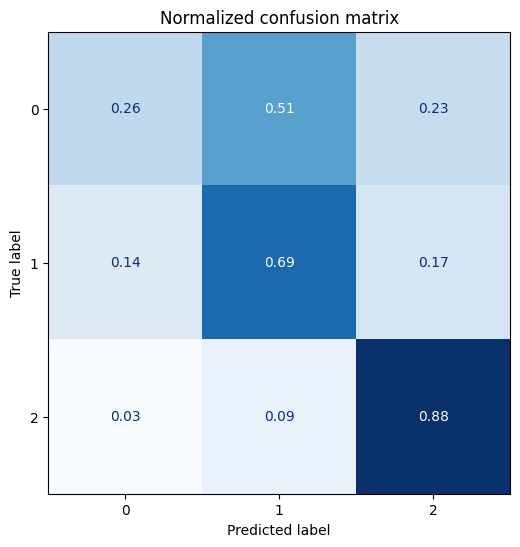

              precision    recall  f1-score   support

           2       0.23      0.26      0.24       120
           1       0.80      0.69      0.74       630
           0       0.78      0.88      0.83       559

    accuracy                           0.73      1309
   macro avg       0.60      0.61      0.60      1309
weighted avg       0.74      0.73      0.73      1309

CUR_FOLD:  4


Map:   0%|          | 0/1226 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.087200,0.990038,0.526101,0.527153
2,0.991300,0.831306,0.672920,0.669104
3,0.855500,0.676798,0.741436,0.722181
4,0.732800,0.492507,0.844209,0.841612
5,0.605400,0.365622,0.898858,0.899112
6,0.502200,0.277643,0.917618,0.917948
7,0.407000,0.206424,0.938825,0.938943
8,0.348100,0.168848,0.952692,0.952985
9,0.297800,0.142069,0.966558,0.966659
10,0.262900,0.133832,0.969005,0.969114


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/Fold4/checkpoint-390


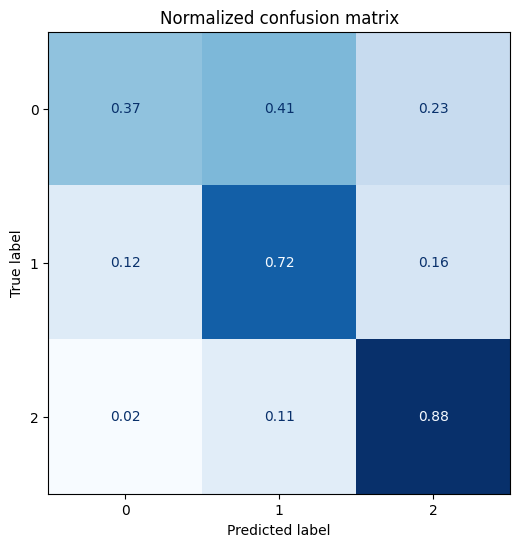

              precision    recall  f1-score   support

           2       0.34      0.37      0.35       120
           1       0.81      0.72      0.76       630
           0       0.79      0.88      0.83       559

    accuracy                           0.75      1309
   macro avg       0.65      0.65      0.65      1309
weighted avg       0.76      0.75      0.75      1309

CUR_FOLD:  5


Map:   0%|          | 0/1348 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.065900,0.951248,0.577893,0.582280
2,0.928100,0.724208,0.738872,0.732471
3,0.764700,0.535322,0.752226,0.748948
4,0.615600,0.436467,0.787092,0.782616
5,0.487100,0.274990,0.893917,0.895861
6,0.385400,0.178754,0.951039,0.951324
7,0.308100,0.138299,0.948813,0.949868
8,0.265900,0.120280,0.949555,0.950473
9,0.218200,0.079916,0.980712,0.980783
10,0.192400,0.076965,0.978487,0.978602


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/Fold5/checkpoint-430


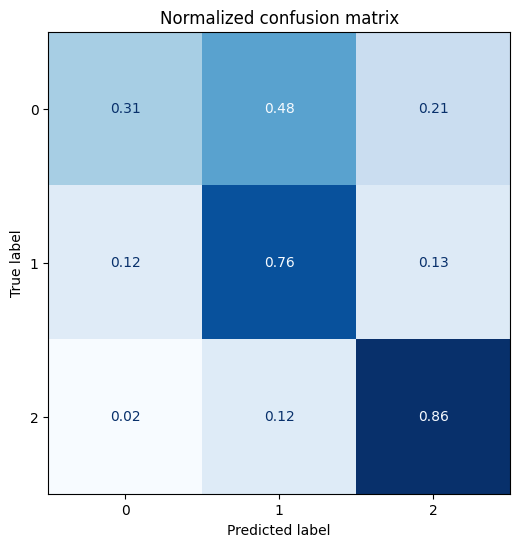

              precision    recall  f1-score   support

           2       0.31      0.31      0.31       120
           1       0.79      0.76      0.77       630
           0       0.82      0.86      0.84       559

    accuracy                           0.76      1309
   macro avg       0.64      0.64      0.64      1309
weighted avg       0.76      0.76      0.76      1309

CUR_FOLD:  6


Map:   0%|          | 0/1470 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.057200,0.920231,0.586395,0.571368
2,0.906000,0.701352,0.696599,0.689619
3,0.722100,0.470219,0.840136,0.841617
4,0.570500,0.327423,0.876190,0.879215
5,0.462100,0.231449,0.919048,0.921088
6,0.359800,0.155983,0.957143,0.957180
7,0.303600,0.111489,0.976190,0.976284
8,0.218800,0.085105,0.976871,0.976927
9,0.197500,0.074683,0.977551,0.977670
10,0.163500,0.061158,0.985714,0.985759


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/Fold6/checkpoint-460


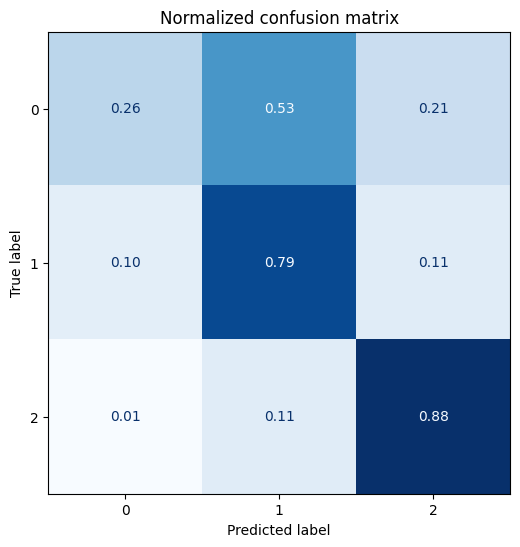

              precision    recall  f1-score   support

           2       0.31      0.26      0.28       120
           1       0.80      0.79      0.79       630
           0       0.84      0.88      0.86       559

    accuracy                           0.78      1309
   macro avg       0.65      0.64      0.64      1309
weighted avg       0.77      0.78      0.77      1309

CUR_FOLD:  7


Map:   0%|          | 0/1592 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.062800,0.940793,0.581658,0.578481
2,0.939300,0.747127,0.728015,0.729656
3,0.773000,0.533252,0.770101,0.777783
4,0.608900,0.372357,0.852387,0.854189
5,0.485800,0.251270,0.918970,0.921381
6,0.383900,0.185416,0.937186,0.938168
7,0.293300,0.116626,0.969221,0.969484
8,0.232400,0.093467,0.971106,0.971262
9,0.176400,0.078382,0.977387,0.977478
10,0.173200,0.069813,0.981156,0.981187


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/Fold7/checkpoint-500


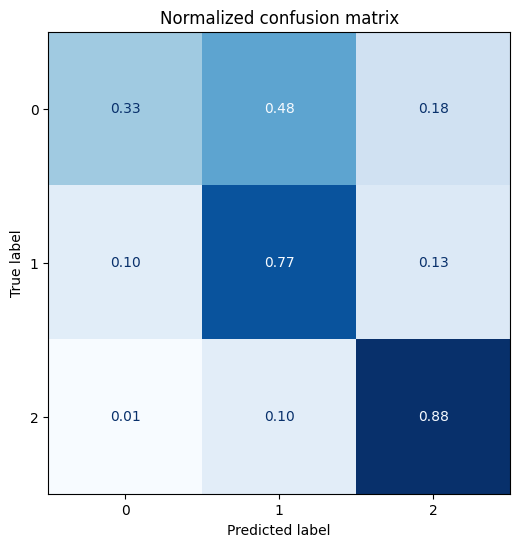

              precision    recall  f1-score   support

           2       0.35      0.33      0.34       120
           1       0.81      0.77      0.79       630
           0       0.83      0.88      0.85       559

    accuracy                           0.78      1309
   macro avg       0.66      0.66      0.66      1309
weighted avg       0.77      0.78      0.77      1309

CUR_FOLD:  8


Map:   0%|          | 0/1714 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.061900,0.923282,0.572929,0.581666
2,0.922000,0.727202,0.678530,0.692220
3,0.772400,0.543383,0.815053,0.813802
4,0.637700,0.401719,0.864061,0.868317
5,0.513600,0.304196,0.880980,0.884735
6,0.421200,0.232602,0.908401,0.911446
7,0.326600,0.161956,0.948658,0.949181
8,0.281600,0.114054,0.969662,0.970025
9,0.225200,0.102206,0.965578,0.966155
10,0.211900,0.087134,0.975496,0.975726


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/Fold8/checkpoint-540


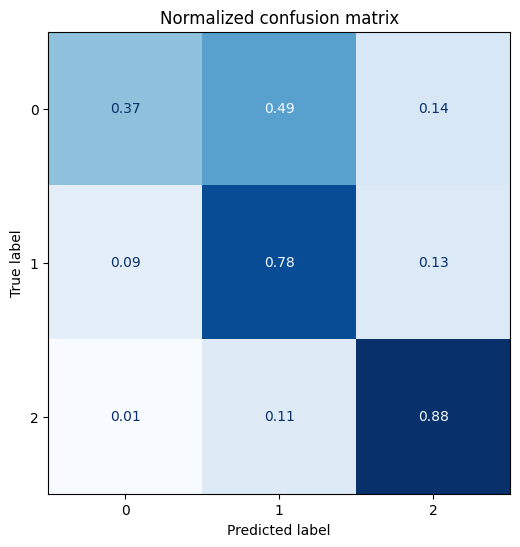

              precision    recall  f1-score   support

           2       0.41      0.37      0.39       120
           1       0.80      0.78      0.79       630
           0       0.84      0.88      0.86       559

    accuracy                           0.78      1309
   macro avg       0.68      0.67      0.68      1309
weighted avg       0.78      0.78      0.78      1309

CUR_FOLD:  9


Map:   0%|          | 0/1835 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.052100,0.888642,0.650136,0.649700
2,0.878800,0.639303,0.751499,0.758038
3,0.703000,0.434226,0.855586,0.855844
4,0.530900,0.291010,0.895368,0.898239
5,0.413600,0.202542,0.921526,0.923844
6,0.328600,0.134984,0.963488,0.963931
7,0.252200,0.099858,0.959673,0.960563
8,0.192800,0.062627,0.980926,0.981120
9,0.155400,0.047105,0.987466,0.987532
10,0.133900,0.043233,0.989646,0.989674


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/Fold9/checkpoint-580


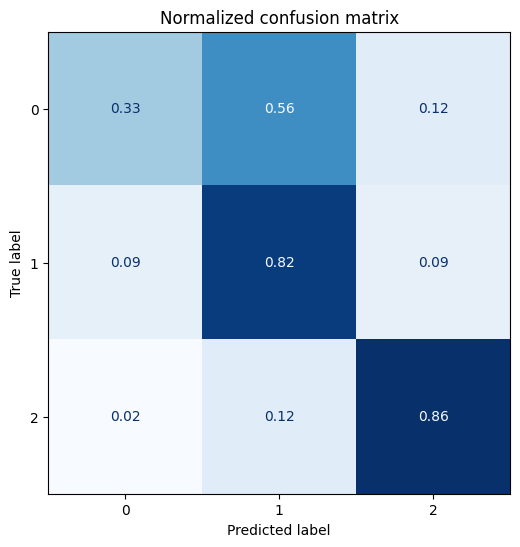

              precision    recall  f1-score   support

           2       0.36      0.33      0.34       120
           1       0.80      0.82      0.81       630
           0       0.87      0.86      0.87       559

    accuracy                           0.79      1309
   macro avg       0.68      0.67      0.67      1309
weighted avg       0.79      0.79      0.79      1309



In [72]:
MODEL_OUTPUT_DIR_BASE = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/additional_analysis/combination_split_answer/"
MODEL_NAME = "cl-tohoku/bert-base-japanese"
RESULT_OUTPUT_DIR_BASE = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/additional_analysis/combination_split_answer/"
BATCH_SIZE = 32

#現在のfoldを管理する
for CUR_FOLD_IDX in range(NUM_FOLDS):
  print("CUR_FOLD: ", CUR_FOLD_IDX)

  #出力ディレクトリの準備
  MODEL_OUTPUT_DIR = MODEL_OUTPUT_DIR_BASE + "Fold" + str(CUR_FOLD_IDX)
  RESULT_OUTPUT_DIR = RESULT_OUTPUT_DIR_BASE + "Fold" + str(CUR_FOLD_IDX) + "/"

  #モデルとトークナイザの初期化
  model, tokenizer = load_bert_model_and_tokenizer()

  #データセットの用意
  tmp_num_fold_lst = range(CUR_FOLD_IDX+1)#1~10までのリストで持つ
  tmp_split_answers = data_answer_unique_with_folds.query('kFold in @tmp_num_fold_lst')
  tmp_split_answers = tmp_split_answers[["word1",	"word2",	"answer",	"labels",	"text",	"kFold"]]

  tmp_data_rubric = data_rubric[["word1",	"word2",	"answer",	"labels",	"text"]]
  tmp_data_rubric["kFold"] = CUR_FOLD_IDX
  tmp_data_rubric_and_split_answers = pd.concat([tmp_data_rubric, tmp_split_answers])
  tmp_data_rubric_and_split_answers = tmp_data_rubric_and_split_answers.reset_index()

  dataset_rubric_and_split_answers, tmp_data_rubric_and_split_answers = create_dataset(tmp_data_rubric_and_split_answers)

  #config関数から呼び出し
  #注: データセット決まってからじゃないと呼び込んじゃダメ
  cur_lc = load_config()
  cur_config = cur_lc.return_config()

  #Trainerのconfig周り
  #TrainingArgumentsの準備
  #ref: https://dev.classmethod.jp/articles/huggingface-usage-early-stopping/
  #ref: https://stackoverflow.com/questions/62525680/save-only-best-weights-with-huggingface-transformers
  training_args = TrainingArguments(
      output_dir=MODEL_OUTPUT_DIR,
      num_train_epochs=10,
      learning_rate=2e-5,
      per_device_train_batch_size=BATCH_SIZE,
      per_device_eval_batch_size=BATCH_SIZE,
      weight_decay=0.01,
      save_strategy="epoch",#4/4まで; noにして, どうなるかを確認する->load_best_model_at_endと重複するからnoはダメらしい
      evaluation_strategy="epoch",
      disable_tqdm=False,
      logging_steps=cur_config["logging_steps"],
      push_to_hub=False,
      log_level="error",
      label_names=['labels'],
      load_best_model_at_end=True,
      save_total_limit=1,
  )

  # Trainerの定義
  trainer = CustomTrainer(
      model=model,
      args=training_args,
      compute_metrics=compute_metrics,
      train_dataset=dataset_rubric_and_split_answers,
      eval_dataset=dataset_rubric_and_split_answers,
      tokenizer=tokenizer,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
  )

  # トレーニング実行
  trainer.train()

  #trainerのbestモデルの場所を書く
  print("best model: ", trainer.state.best_model_checkpoint)

  #モデルの保存を明示的に書く
  trainer.save_model()

  #評価結果を保存するためのディレクトリの作成
  os.makedirs(RESULT_OUTPUT_DIR)

  #評価する
  preds_output = trainer.predict(dataset_eval_unique_reset_index_encoded)
  y_preds = np.argmax(preds_output.predictions, axis=1)
  y_valid = np.array(data_eval_unique_reset_index["labels"])
  data_eval_unique_reset_index["pred"] = y_preds

  #confusion_matrixの表示と保存
  plot_confusion_matrix(data_eval_unique_reset_index["pred"], data_eval_unique_reset_index["labels"], RESULT_OUTPUT_DIR)

  #classification_reportの表示と保存
  categories = data_eval_unique_reset_index['labels'].unique().tolist()
  categories = list(map(str, categories))
  classification_report_txt = classification_report(y_valid, y_preds, target_names=categories)
  print(classification_report_txt)

  with open(RESULT_OUTPUT_DIR + "classification_report.txt", "w") as output_file:
    output_file.write(classification_report_txt)

  tmp_data_rubric_and_split_answers.to_csv(RESULT_OUTPUT_DIR + "data_train.csv", index=False)
  data_eval_unique_reset_index.to_csv(RESULT_OUTPUT_DIR + "data_test.csv", index=False)